# Hyper-parameter tuning

In [1]:
%load_ext autoreload
%autoreload 2

!python --version

Python 3.7.6


In [2]:
import sys
sys.path.append('..')

In [123]:
def plot_grid_search_cv_results(clf, distributions, **kwargs):    
    heatmap=kwargs.get('heatmap', False)
    figsize=kwargs.get('figsize', (20, 5))
    
    df_gridsearch = pd.DataFrame(clf.cv_results_)
    
    params_values = df_gridsearch.params
    raw_params_names = list(distributions.keys())
    params_names = [f'param_{param}' for param in raw_params_names]
    max_scores = df_gridsearch.groupby(params_names).max()

    if len(params_names) == 1 and heatmap == True:
        return
    
    if heatmap == False:
        fig, axs = plt.subplots(nrows=len(raw_params_names), figsize=(figsize[0], figsize[1] * len(raw_params_names)))
        
        for index, param_name in enumerate(raw_params_names):
            mean_test_scores = list(max_scores.mean_test_score)
            param_values = [param_value[param_name] for param_value in params_values]

            df = pd.DataFrame({ param_name: param_values, 'mean_test_score': mean_test_scores })

            if type(axs) is np.ndarray:
                sns.barplot(data=df, x=param_name, y='mean_test_score', ax=axs[index])
            else:
                sns.barplot(data=df, x=param_name, y='mean_test_score')
    else:
        max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
        
        fig, axs = plt.subplots(figsize=figsize)
        
        sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g',ax=axs);
        
    return clf.best_params_, clf.best_score_

## Classification

In [3]:
from src.evaluation import custom_classification_report

### Load the dataset

In [4]:
from src.dataset import DatasetForClassification

dataset = DatasetForClassification('../data/fifa_processed_for_cls.csv', ['Position (4)', 'Position (13)'])

### Classification of "Position (4)"

In [11]:
X_train, X_test, y_train, y_test = dataset.get_data('Position (4)')

labels = dataset.get_labels('Position (4)')

Do oversampling based on the results from 09_SMOTE.ipynb. We use the method which performed the best.

In [12]:
from imblearn.over_sampling import SVMSMOTE

sm = SVMSMOTE(
    k_neighbors=20,
    m_neighbors=40,
    n_jobs=-1,
    out_step=0.5,
    random_state=42,
    sampling_strategy='auto',
    svm_estimator=None)

X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

Select features based on the results from 10_feature_selection.ipynb. We use the method which performed the best.

In [21]:
from sklearn.feature_selection import GenericUnivariateSelect, chi2

sel = GenericUnivariateSelect(chi2, 'k_best', param=42)
sel.fit(X_train, y_train)

selected_columns = []

for selected, column in zip(sel.get_support(), X_train_res.columns):
    if selected:
        selected_columns.append(column)

In [23]:
X_train_res_sel = X_train_res[selected_columns]
X_test_sel = X_test[selected_columns]

#### Training

In [31]:
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier

attack
precision: 0.8117647058823529
recall: 0.8466257668711656
f1-score: 0.8288288288288288
support: 652


defense
precision: 0.9394987035436474
recall: 0.9403114186851211
f1-score: 0.9399048854301774
support: 1156


goalkeeper
precision: 1.0
recall: 1.0
f1-score: 1.0
support: 407


middle
precision: 0.8795093795093795
recall: 0.8614840989399293
f1-score: 0.8704034273473759
support: 1415


accuracy: 0.8994490358126722


macro avg
precision: 0.907693197233845
recall: 0.912105321124054
f1-score: 0.9097842854015955
support: 3630


weighted avg
precision: 0.8999550582747995
recall: 0.8994490358126722
f1-score: 0.8995998054132833
support: 3630


F1
micro: 0.8994490358126722
macro: 0.9097842854015955


CPU times: user 2.28 s, sys: 572 ms, total: 2.85 s
Wall time: 3min 3s


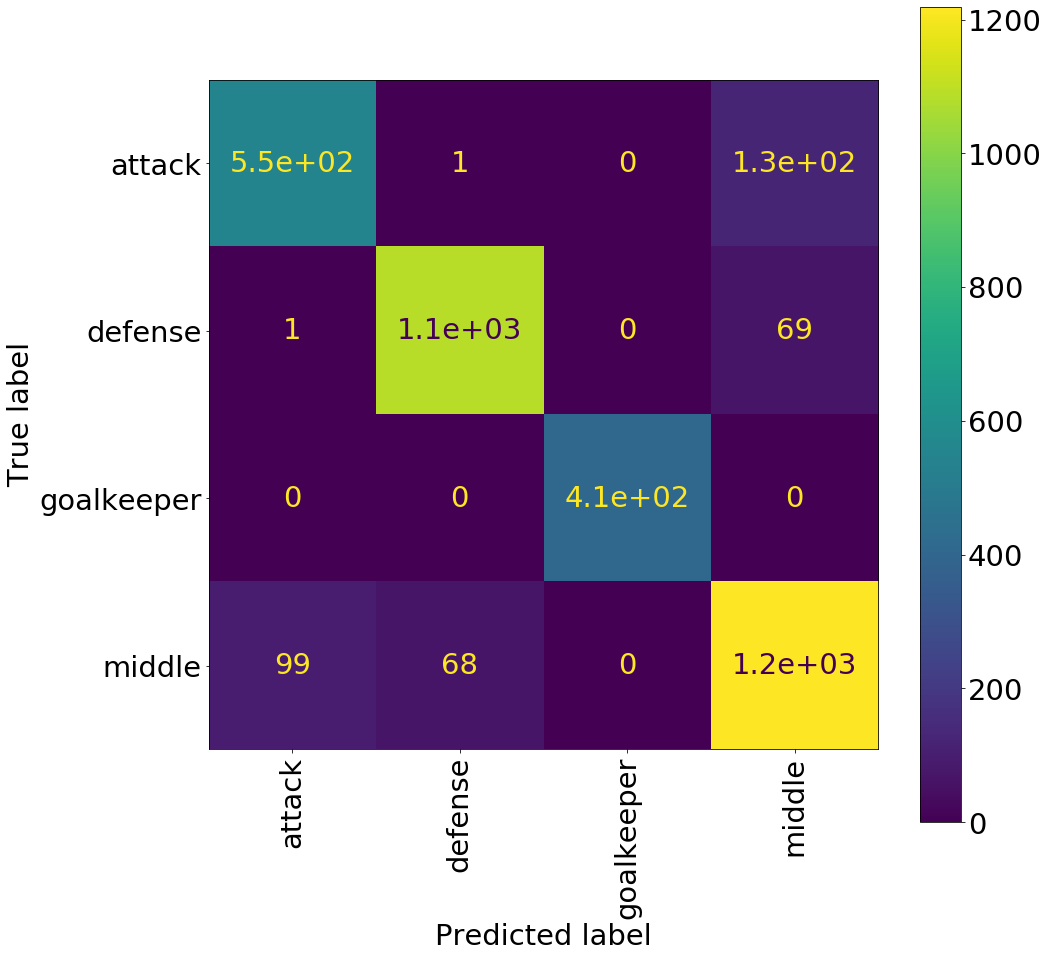

In [30]:
%%time

clf_lr = LogisticRegression(max_iter=10000, n_jobs=-1)
clf_rf = RandomForestClassifier(random_state=42)
clf_gb = GradientBoostingClassifier(n_estimators=100)
clf_ada = AdaBoostClassifier(n_estimators=100, base_estimator=RandomForestClassifier(random_state=42), random_state=42)

estimators = [
    ('lr', clf_lr),
    ('rf', clf_rf),
    ('gb', clf_gb),
    ('ada', clf_ada)
]

clf = StackingClassifier(estimators=estimators, cv=5, n_jobs=-1, final_estimator=LogisticRegression(max_iter=10000, n_jobs=-1))

clf.fit(X_train, y_train)

custom_classification_report(clf, labels, X_test, y_test, figsize=(15, 15))

#### Evaluate

attack
precision: 0.8117647058823529
recall: 0.8466257668711656
f1-score: 0.8288288288288288
support: 652


defense
precision: 0.9394987035436474
recall: 0.9403114186851211
f1-score: 0.9399048854301774
support: 1156


goalkeeper
precision: 1.0
recall: 1.0
f1-score: 1.0
support: 407


middle
precision: 0.8795093795093795
recall: 0.8614840989399293
f1-score: 0.8704034273473759
support: 1415


accuracy: 0.8994490358126722


macro avg
precision: 0.907693197233845
recall: 0.912105321124054
f1-score: 0.9097842854015955
support: 3630


weighted avg
precision: 0.8999550582747995
recall: 0.8994490358126722
f1-score: 0.8995998054132833
support: 3630


F1
micro: 0.8994490358126722
macro: 0.9097842854015955




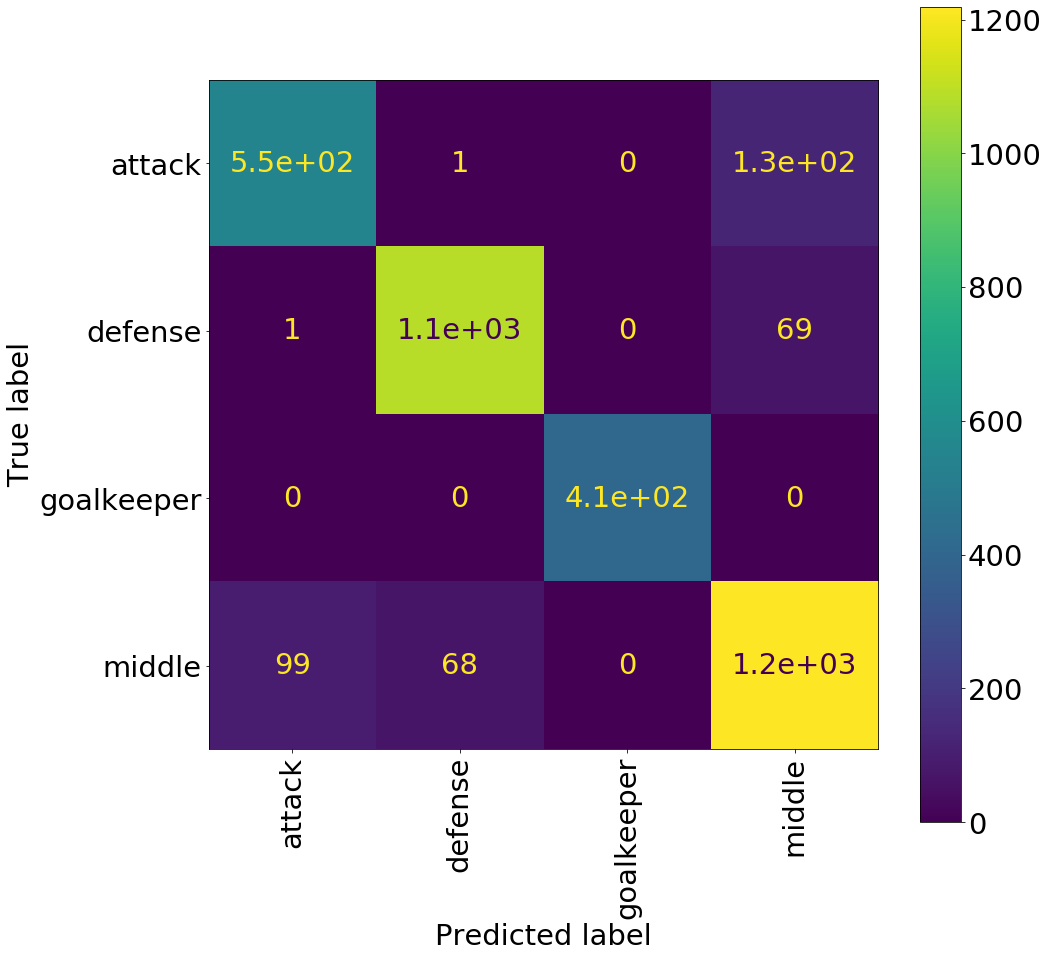

In [32]:
custom_classification_report(clf, labels, X_test, y_test, figsize=(15, 15))

### Classification of "Position (13)"

Oversampling.

In [ ]:
from imblearn.over_sampling import SVMSMOTE

sm = SVMSMOTE(
    k_neighbors=20,
    m_neighbors=40,
    n_jobs=-1,
    out_step=0.5,
    random_state=42,
    sampling_strategy='auto',
    svm_estimator=None)

X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

Feature selection.

In [ ]:
from sklearn.feature_selection import GenericUnivariateSelect, chi2

sel = GenericUnivariateSelect(chi2, 'k_best', param=42)
sel.fit(X_train, y_train)

selected_columns = []

for selected, column in zip(sel.get_support(), X_train_res.columns):
    if selected:
        selected_columns.append(column)

In [ ]:
X_train_res_sel = X_train_res[selected_columns]
X_test_sel = X_test[selected_columns]

#### Training

In [ ]:
TODO

#### Evaluate

In [ ]:
TODO

### Conclusion

In [ ]:
TODO

## Regression

In [141]:
from src.evaluation import custom_regression_report

### Load the dataset

In [5]:
from src.dataset import DatasetForRegression

dataset = DatasetForRegression('../data/fifa_processed_for_reg.csv', ['Value'])

In [6]:
X_train, X_test, y_train, y_test = dataset.get_data('Value')

We will compare all features with the selected features from `10_feature_selection.ipynb` ('Age', 'Overall', 'Potential').

### Train

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

We will use GradientBoostingRegressor since it was the best regressor.

We will do hyper-parameter tunning in several steps, we will start with the most important parameters (those) which make a significant impact on a model. We followed this [tutorial](https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/).

Firstly we will try different number of estimators.

In [81]:
%%time

gbr = GradientBoostingRegressor(random_state=42)
distributions = { "n_estimators": range(50, 600, 10) }

clf = GridSearchCV(gbr, distributions, n_jobs=-1, scoring="neg_root_mean_squared_error", verbose=2, return_train_score=True)

search_1_clf = clf.fit(X_train, y_train)

Fitting 5 folds for each of 55 candidates, totalling 275 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 14.0min
[Parallel(n_jobs=-1)]: Done 275 out of 275 | elapsed: 38.6min finished


CPU times: user 1min 2s, sys: 1.16 s, total: 1min 3s
Wall time: 39min 33s


({'n_estimators': 590}, -633697.8569601651)

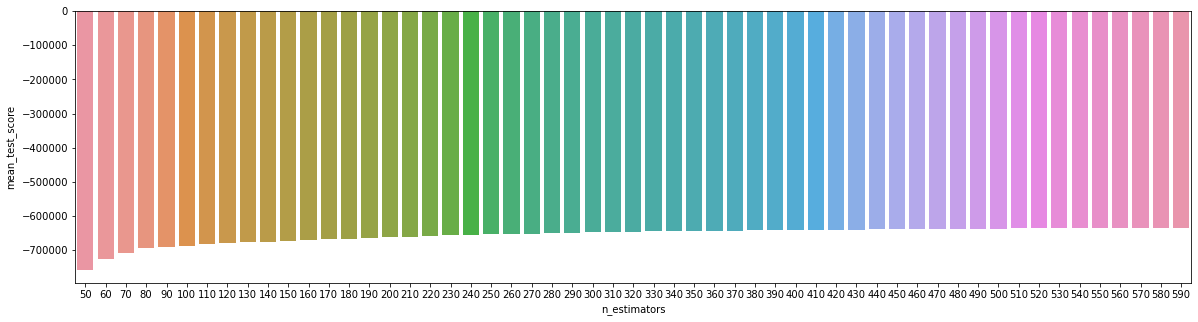

In [95]:
plot_grid_search_cv_results(search_1_clf, distributions)

Since the decrease from 200 was really minor but the training duration increased significantly, we will use 200 estimators.

We will hyper-tune max_depth & min_samples_split.

In [99]:
%%time

gbr = GradientBoostingRegressor(n_estimators=200, random_state=42)

distributions = { "max_depth": range(5, 16, 2), "min_samples_split": range(200, 1001, 200) }

clf = GridSearchCV(gbr, distributions, n_jobs=-1, scoring="neg_root_mean_squared_error", verbose=2, return_train_score=True)

search_2_clf = clf.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 35.6min finished


CPU times: user 22.3 s, sys: 262 ms, total: 22.6 s
Wall time: 35min 59s


({'max_depth': 5, 'min_samples_split': 200}, -761604.3735874773)

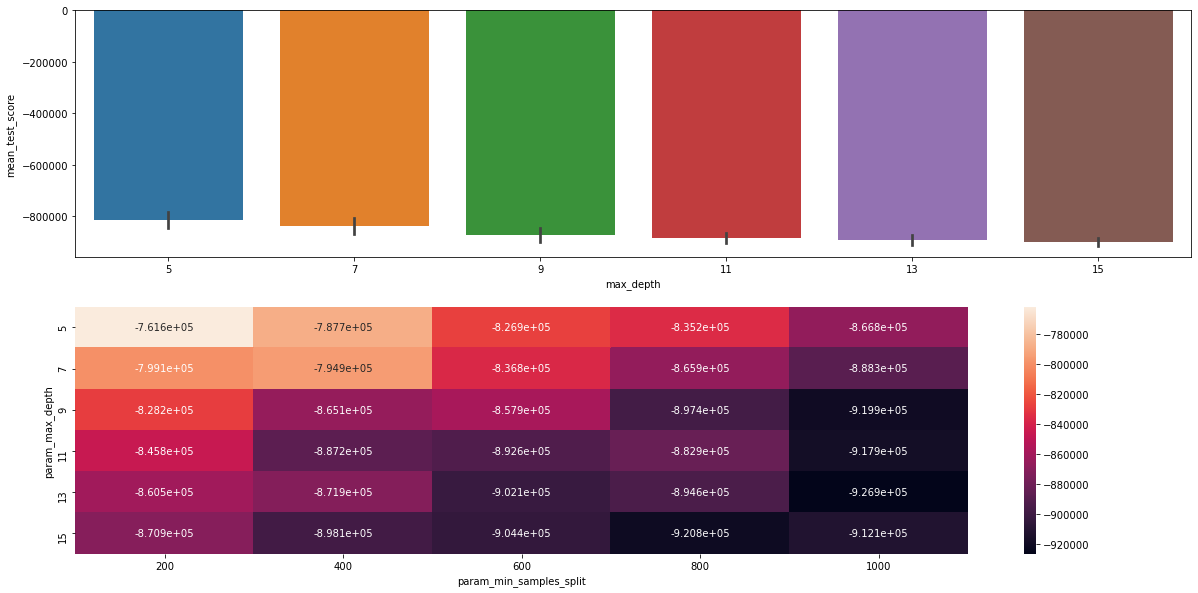

In [108]:
plot_grid_search_cv_results(search_2_clf, distributions)
plot_grid_search_cv_results(search_2_clf, distributions, heatmap=True)

There is not an improvement in the model...

In [125]:
%%time

gbr = GradientBoostingRegressor(n_estimators=200, random_state=42)

distributions = { "max_depth": range(3, 10, 2), "min_samples_split": range(2, 100, 5) }

clf = GridSearchCV(gbr, distributions, n_jobs=-1, scoring="neg_root_mean_squared_error", verbose=2, return_train_score=True)

search_2a_clf = clf.fit(X_train, y_train)

(20, 5)


({'max_depth': 3, 'min_samples_split': 12}, -661813.3966771839)

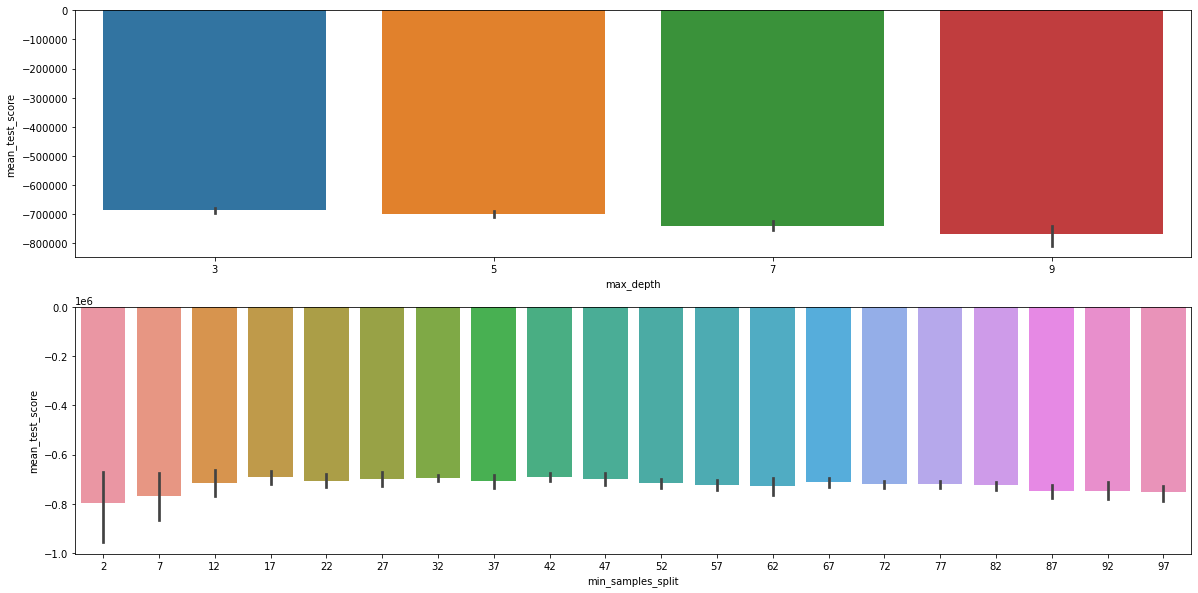

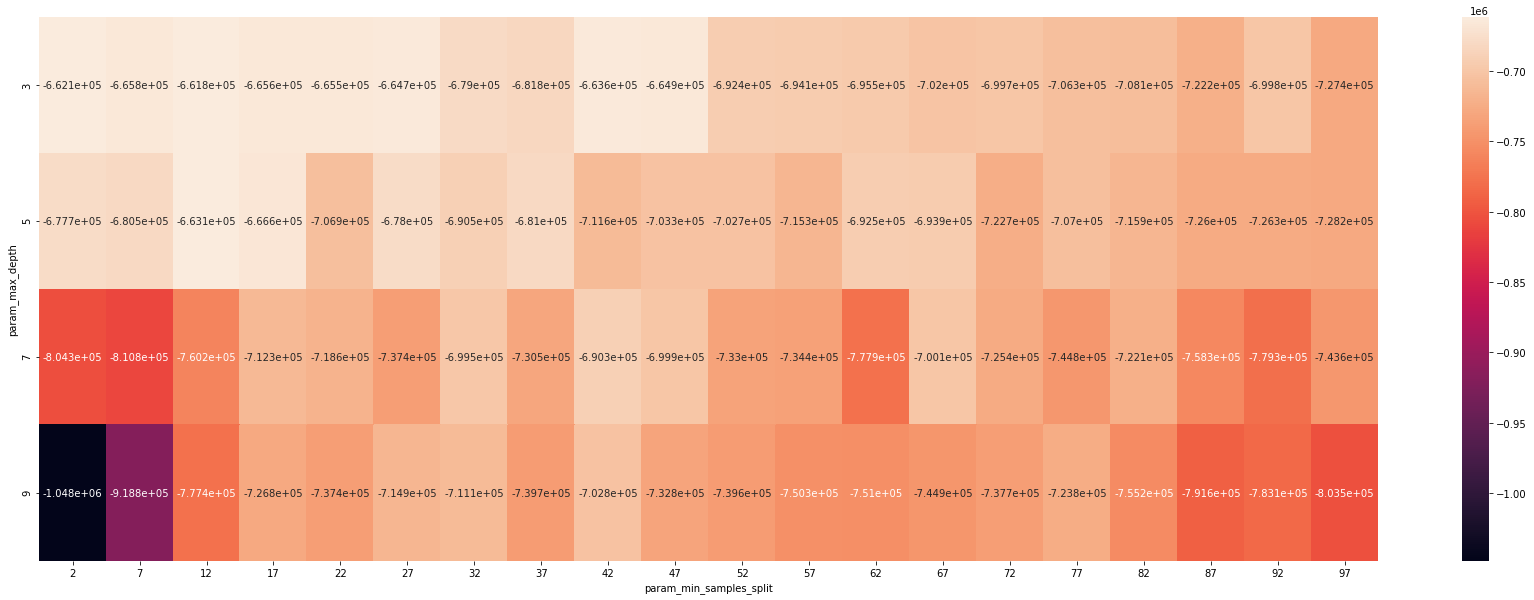

In [121]:
plot_grid_search_cv_results(search_2a_clf, distributions)
plot_grid_search_cv_results(search_2a_clf, distributions, heatmap=True, figsize=(30, 10))

We will use `max_depth=3` and `min_samples_split=12`.

We will hyper-tune min_samples_split & min_samples_leaf.

In [155]:
gbr = GradientBoostingRegressor(n_estimators=200, max_depth=3, min_samples_split=13, random_state=42)

distributions = { "min_samples_split": range(2, 50, 8), "min_samples_leaf": range(1, 20, 4) }

clf = GridSearchCV(gbr, distributions, n_jobs=-1, scoring="neg_root_mean_squared_error", verbose=2, return_train_score=True)

search_3_clf = clf.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 19.9min finished


({'min_samples_leaf': 5, 'min_samples_split': 42}, -620656.5336109585)

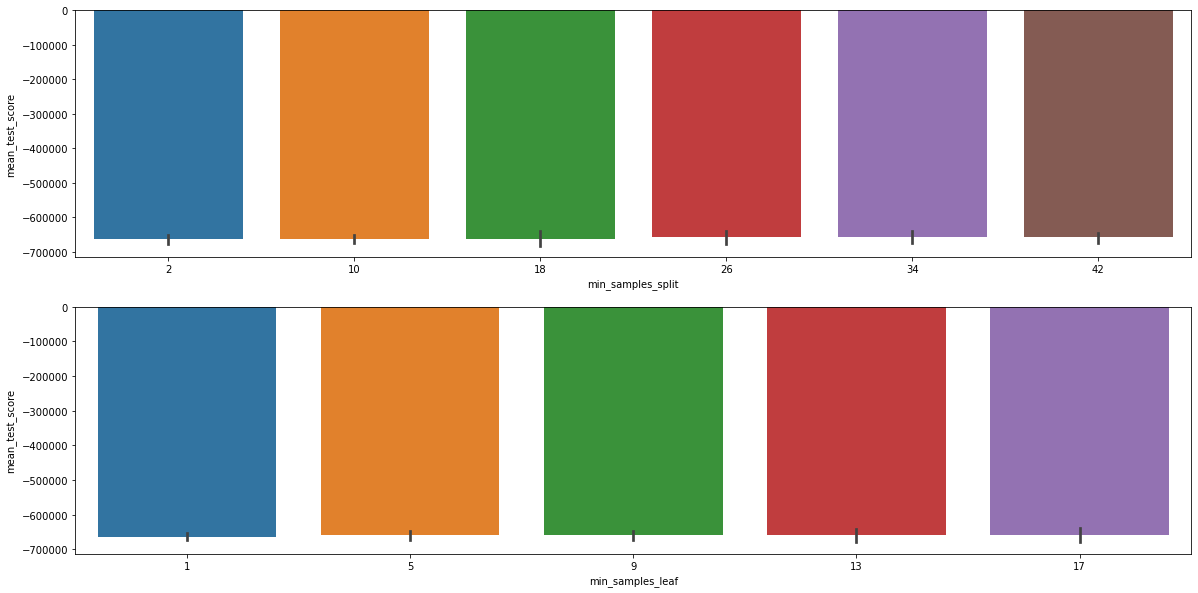

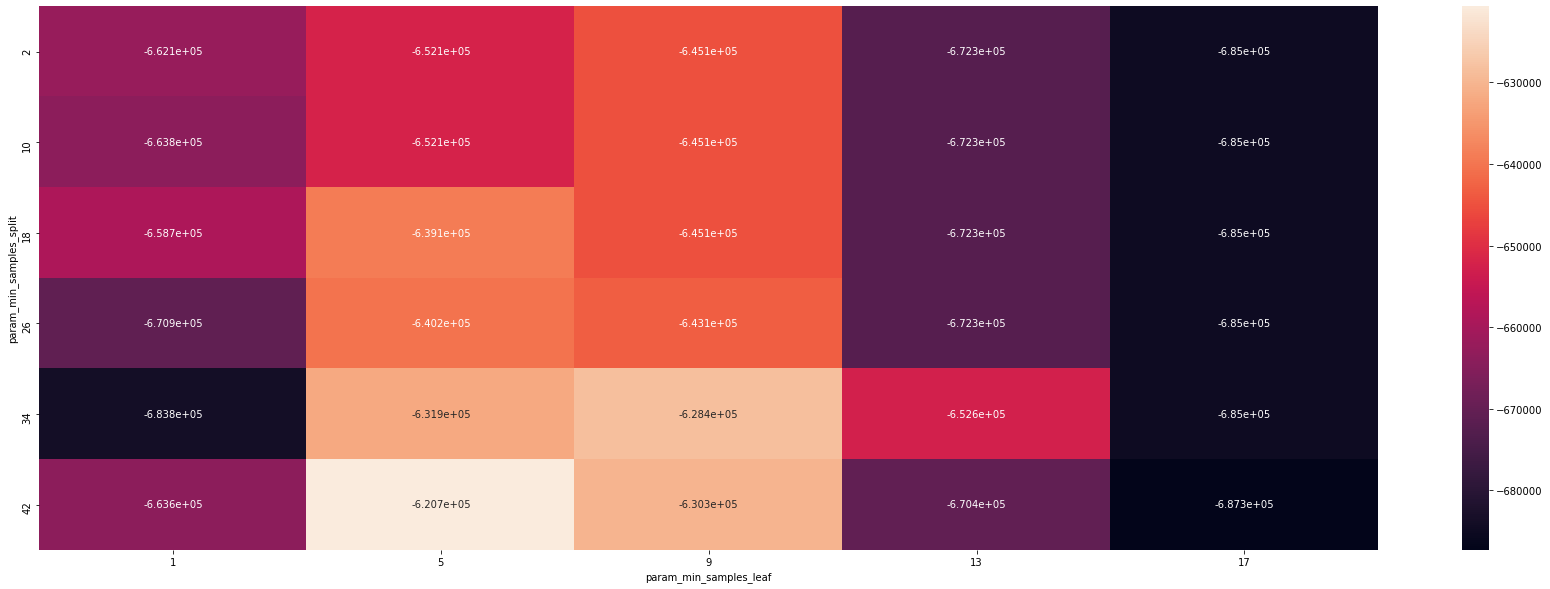

In [156]:
plot_grid_search_cv_results(search_3_clf, distributions)
plot_grid_search_cv_results(search_3_clf, distributions, heatmap=True, figsize=(30, 10))

We will use `main_samples_leaf=5` and `min_samples_split=42`.

We will hyper-tune max_features.

In [157]:
gbr = GradientBoostingRegressor(min_samples_leaf=5, n_estimators=200, max_depth=3, min_samples_split=42, random_state=42)

distributions = { "max_features": range(3, 80, 5) }

clf = GridSearchCV(gbr, distributions, n_jobs=-1, scoring="neg_root_mean_squared_error", verbose=2, return_train_score=True)

search_4_clf = clf.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   54.1s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  3.9min finished


({'max_features': 58}, -600557.347872484)

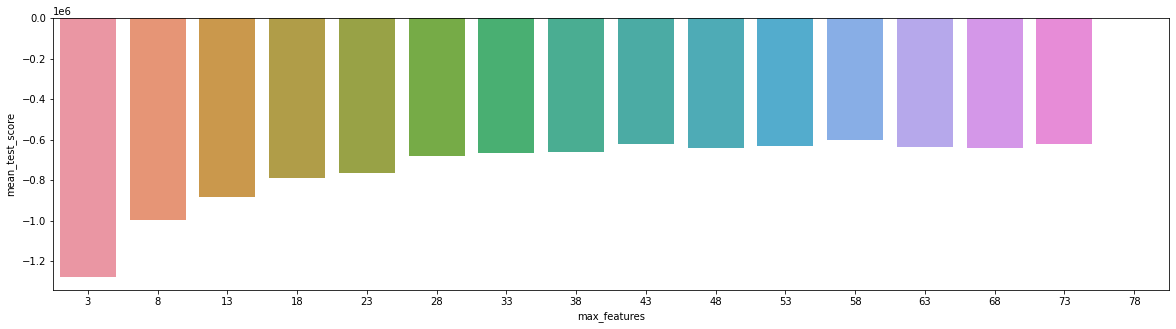

In [158]:
plot_grid_search_cv_results(search_4_clf, distributions)

We won't use this hyper-parameter since there is not a significant improvement.

We will hyper-tune subsample.

In [159]:
gbr = GradientBoostingRegressor(min_samples_leaf=5, n_estimators=200, max_depth=3, min_samples_split=42, random_state=42, max_features=58)

distributions = { "subsample": [0.6, 0.7, 0.75, 0.8, 0.85, 0.9] }

clf = GridSearchCV(gbr, distributions, n_jobs=-1, scoring="neg_root_mean_squared_error", verbose=2, return_train_score=True)

search_5_clf = clf.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.0min finished


({'subsample': 0.8}, -651226.4752937529)

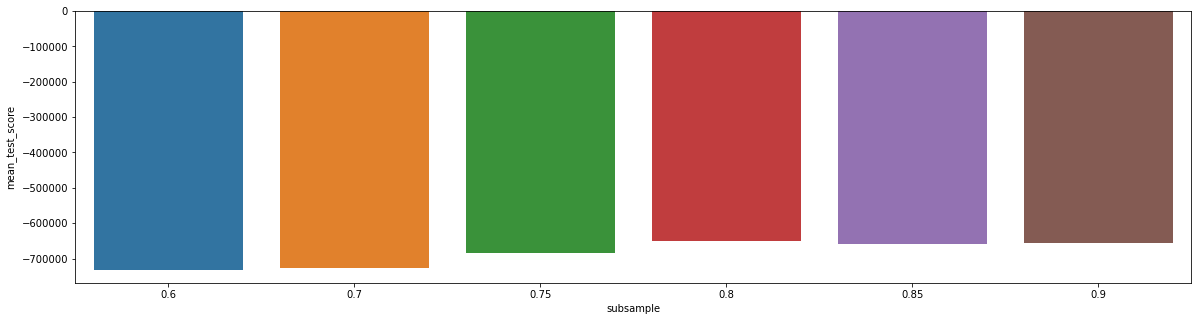

In [160]:
plot_grid_search_cv_results(search_5_clf, distributions)

### Evaluation

#### Baseline model

MSE: 271874806716.87653
RMSE: 521416.1550209933
Explained variance - uniform_average (higher is better): 0.9920410552103963
Explained variance - variance_weighted (higher is better): 0.9920410552103963




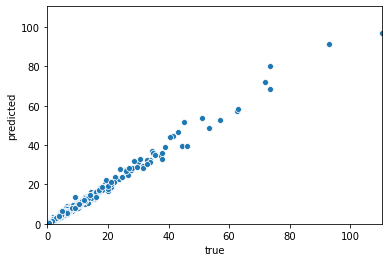

In [145]:
gbr_baseline = GradientBoostingRegressor(random_state=42)

gbr_baseline.fit(X_train, y_train)

custom_regression_report(clf, X_test, y_test)

#### The new model based on hyperparameter search

MSE: 344572331593.8911
RMSE: 587002.8378073578
Explained variance - uniform_average (higher is better): 0.9899151593081326
Explained variance - variance_weighted (higher is better): 0.9899151593081326




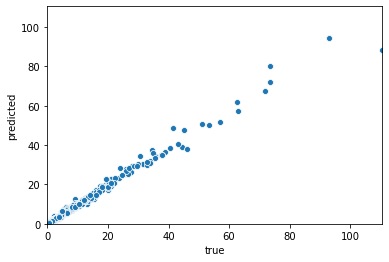

In [161]:
gbr = GradientBoostingRegressor(min_samples_leaf=5, n_estimators=200, max_depth=3, min_samples_split=42, random_state=42)

gbr.fit(X_train, y_train)

custom_regression_report(gbr, X_test, y_test)

The new model is a little bit worse...

Doing hyper-parameter tunning in steps did not result in a good solution.

We will do hyper-parameter search in one run.

In [162]:
gbr = GradientBoostingRegressor(n_estimators=200, max_depth=3, min_samples_split=13, random_state=42)

distributions = { 
    "max_depth": range(1, 10, 2),
    "min_samples_split": range(2, 50, 8),
    "min_samples_leaf": range(1, 20, 4)
}

clf = GridSearchCV(gbr, distributions, n_jobs=-1, scoring="neg_root_mean_squared_error", verbose=2, return_train_score=True)

search_clf = clf.fit(X_train, y_train)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 30.0min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 79.8min
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed: 101.8min finished


({'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 42},
 -620656.5336109585)

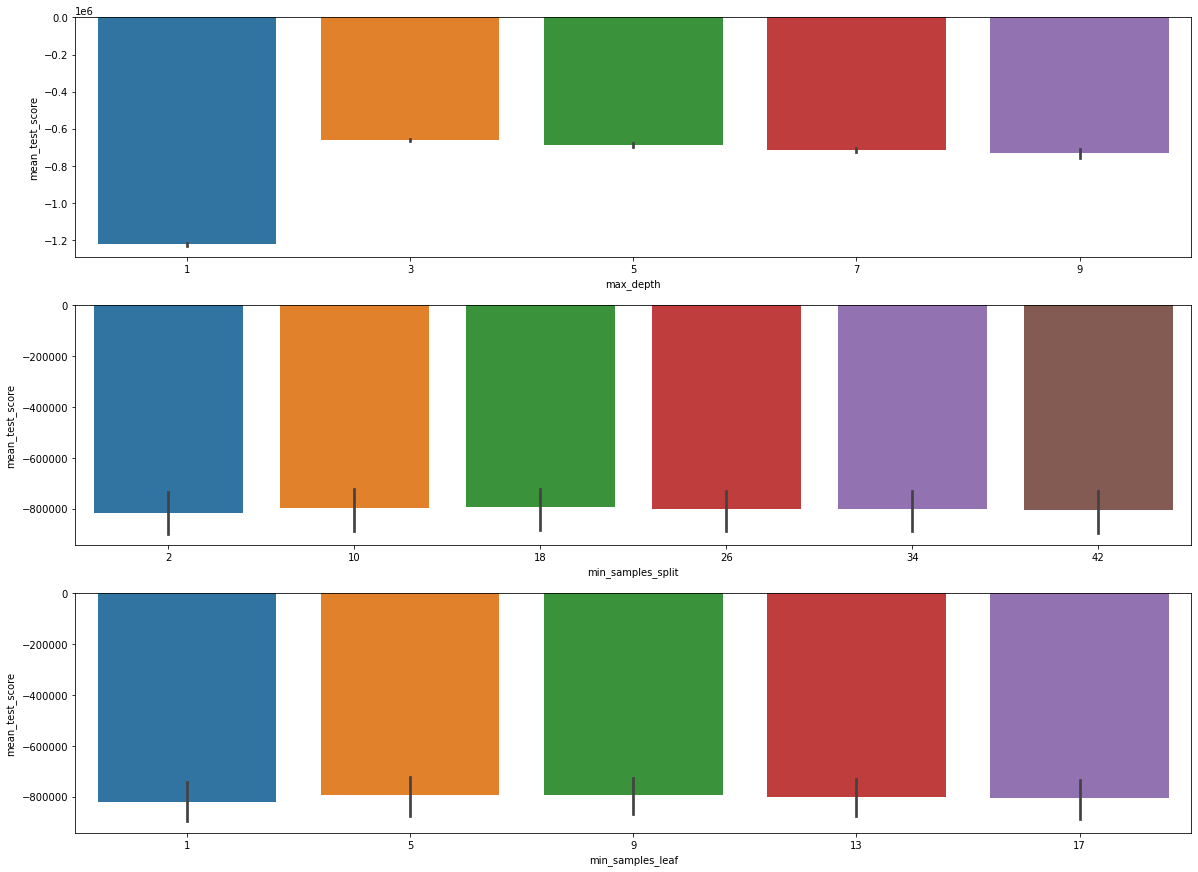

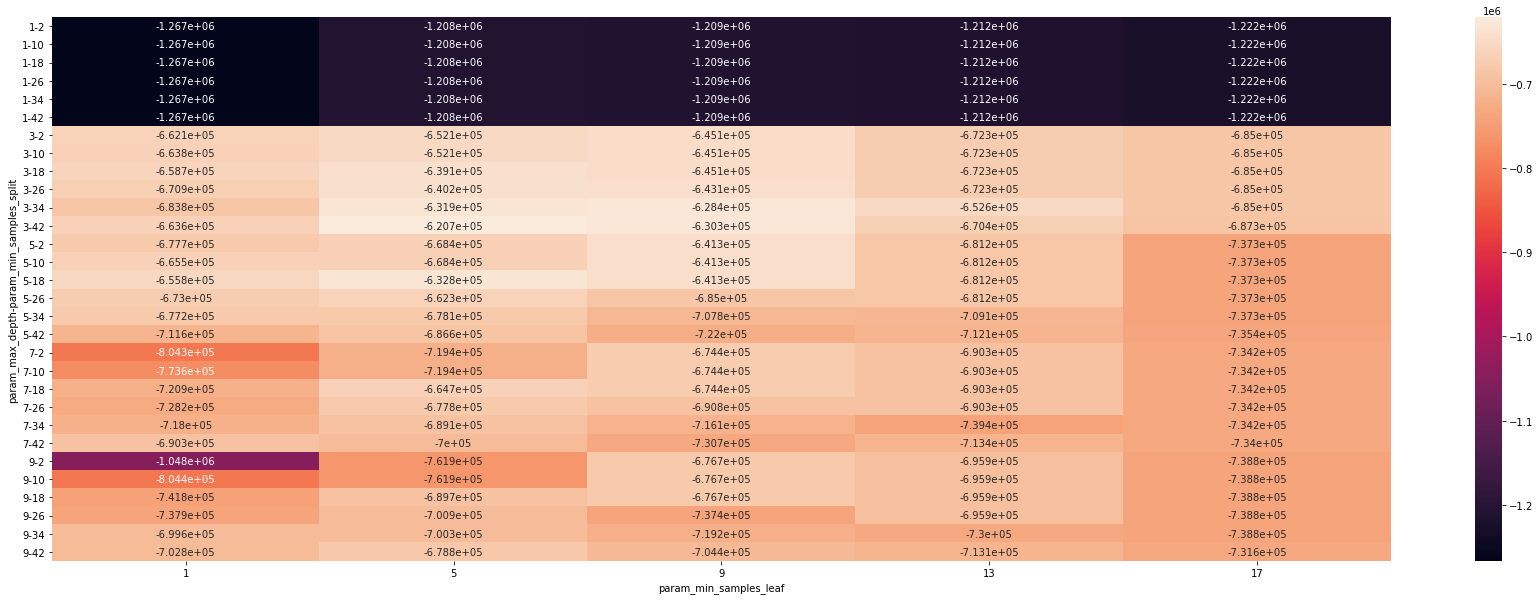

In [166]:
plot_grid_search_cv_results(search_clf, distributions)
plot_grid_search_cv_results(search_clf, distributions, heatmap=True, figsize=(30, 10))

We will try the model based on this.

MSE: 344572331593.8911
RMSE: 587002.8378073578
Explained variance - uniform_average (higher is better): 0.9899151593081326
Explained variance - variance_weighted (higher is better): 0.9899151593081326




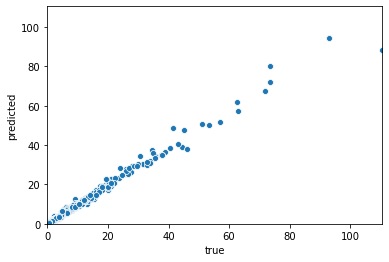

In [176]:
gbr = GradientBoostingRegressor(max_depth=3, min_samples_split=42, min_samples_leaf=5, n_estimators=200, random_state=42)

gbr.fit(X_train, y_train)

custom_regression_report(gbr, X_test, y_test)

The model is worse again. We achieved a better model when we tried to change the params manually (we used the knowledge from the previous results).

MSE: 256339401143.6518
RMSE: 506299.71473787323
Explained variance - uniform_average (higher is better): 0.9925001986544478
Explained variance - variance_weighted (higher is better): 0.9925001986544478




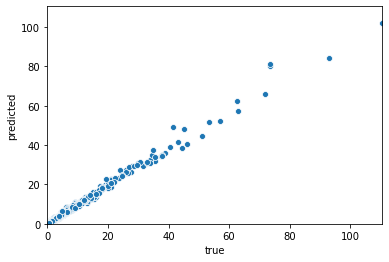

In [175]:
gbr = GradientBoostingRegressor(max_depth=3, min_samples_split=13, n_estimators=200, random_state=42)

gbr.fit(X_train, y_train)

custom_regression_report(gbr, X_test, y_test)

The final modal can predict the value of the player with error of 500K.

### Conclusion

We were able to train a model with RMSE: 506299.71. What is a significant improvement with our first model in `06_model_selection_regression.ipynb`.